# Angler tests

In [1]:
import sys; sys.path.append("../..") # use local neural_maxwell package

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

from tqdm import tqdm, tqdm_notebook

from angler import Simulation
from angler.derivatives import unpack_derivs

from neural_maxwell.datasets.generators import * 
from neural_maxwell.constants import *
from neural_maxwell.datasets.fdfd import *

np.set_printoptions(precision=3)

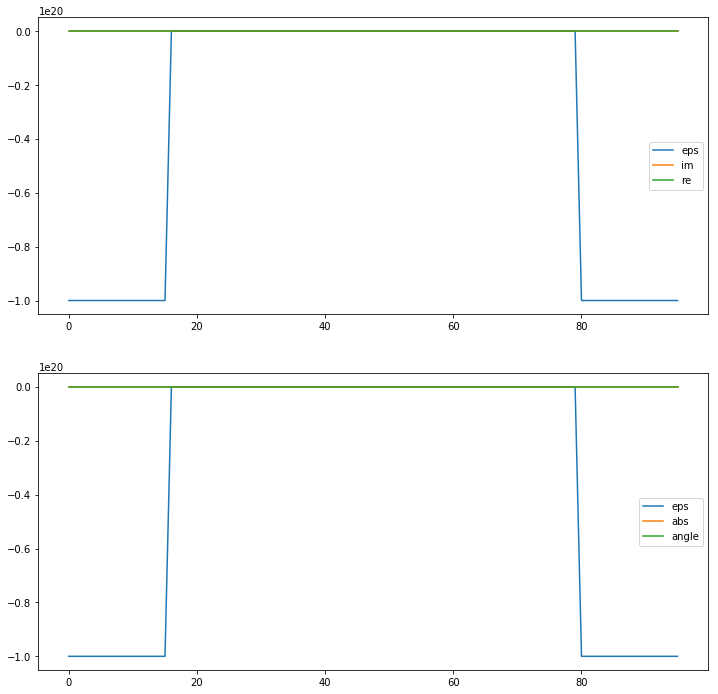

In [2]:
# epsilons = perm_random_number_alternating_layers(s=DEVICE_LENGTH, eps1=1.0, eps2=eps_si)
epsilons = 2*np.ones(DEVICE_LENGTH)
# epsilons[150:] = 3

total_length = DEVICE_LENGTH + 2 * BUFFER_LENGTH + 2 * NPML
start = NPML + BUFFER_LENGTH
end = start + DEVICE_LENGTH

# need to use two rows to avoid issues with fd-derivative operators
# perms = np.ones((2, total_length), dtype=np.float64)
perms = np.ones(total_length, dtype=np.float64)


# set permittivity and reflection zone
# perms[:, :start] = BUFFER_PERMITTIVITY
# perms[:, start:end] = epsilons
# perms[:, end:] = BUFFER_PERMITTIVITY

perms[start-BUFFER_LENGTH:start] = BUFFER_PERMITTIVITY
perms[start:end] = epsilons
perms[end:end+BUFFER_LENGTH] = BUFFER_PERMITTIVITY

src_x = NPML + BUFFER_LENGTH # int(DEVICE_LENGTH / 2)

sim = Simulation(OMEGA_1550, perms, dL, [NPML, 0], "Ez", L0=L0)


# sim.src[:, src_x] = 1j
sim.src[src_x] = 1j

clip0 = NPML + BUFFER_LENGTH
clip1 = -(NPML + BUFFER_LENGTH)

Hx, Hy, Ez = sim.solve_fields()
# perms = perms[:, clip0:clip1]
# Hx = Hx[:, clip0:clip1]
# Hy = Hy[:, clip0:clip1]
# Ez = Ez[:, clip0:clip1]

fix, ax = plt.subplots(2,1, figsize = (12,12))
ax[0].plot(perms, label="eps")
ax[0].plot(np.imag(Ez), label="im")
ax[0].plot(np.real(Ez), label="re")
ax[0].vlines(src_x, -10,10)
# ax[0].set_ylim([-10,10])
ax[0].legend()


ax[1].plot(perms, label="eps")
ax[1].plot(np.abs(Ez), label="abs")
ax[1].plot(np.angle(Ez), label="angle")
ax[1].vlines(src_x, -10,10)
ax[1].legend()
# ax[1].set_ylim([-10,10])
plt.show()


# fix, ax = plt.subplots(2,1, figsize = (12,12))
# ax[0].plot(perms[0], label="eps")
# ax[0].plot(np.imag(Ez[0]), label="im")
# ax[0].plot(np.real(Ez[0]), label="re")
# ax[0].vlines(src_x, -10,10)
# ax[0].legend()

# ax[1].plot(perms[0], label="eps")
# ax[1].plot(np.abs(Ez[0]), label="abs")
# # ax[1].plot(np.angle(Ez[0])+DL*np.abs(np.arange(-total_length//2, total_length//2)), label="angle")
# ax[1].plot(np.angle(Ez[0]), label="angle")
# ax[1].legend()
# plt.show()

In [27]:
eps = PermittivityGenerators1D.random_layers()
sim = Simulation1D()
permittivities, src_x, Hx, Hy, Ez = sim.solve(eps)
np_curl_curl_op, _ = sim.get_operators()
curl_curl_op = torch.tensor(np.asarray(np.real(np_curl_curl_op)))
Ez = np.real(Ez)

In [28]:
permittivities

array([-1.000e+20, -1.000e+20, -1.000e+20, -1.000e+20, -1.000e+20,
       -1.000e+20, -1.000e+20, -1.000e+20, -1.000e+20, -1.000e+20,
       -1.000e+20, -1.000e+20, -1.000e+20, -1.000e+20, -1.000e+20,
       -1.000e+20,  1.563e+01,  1.563e+01,  1.563e+01,  1.563e+01,
        1.563e+01,  1.563e+01,  1.563e+01,  1.563e+01,  1.563e+01,
        1.563e+01,  1.563e+01,  1.563e+01,  1.563e+01,  1.563e+01,
        1.563e+01,  1.563e+01,  1.563e+01,  1.568e+01,  1.568e+01,
        1.568e+01,  7.522e+00,  7.522e+00,  7.522e+00,  7.522e+00,
        7.522e+00,  7.522e+00,  7.522e+00,  7.522e+00,  1.298e+01,
        1.298e+01,  1.298e+01,  1.298e+01,  1.298e+01,  1.298e+01,
        1.298e+01,  1.298e+01,  1.298e+01,  1.298e+01,  1.298e+01,
        1.298e+01,  1.298e+01,  1.298e+01,  1.298e+01,  1.298e+01,
        1.298e+01,  1.298e+01,  1.298e+01,  1.776e+01,  1.776e+01,
        1.776e+01,  1.776e+01,  1.776e+01,  1.776e+01,  1.776e+01,
        1.776e+01,  1.776e+01,  1.776e+01,  1.776e+01,  1.776e

In [29]:
residuals = maxwell_residual(torch.tensor([Ez]), torch.tensor([permittivities]), curl_curl_op, add_padding=False)

In [30]:
residuals.numpy().flatten()

array([-7.471e-10, -1.013e-09, -6.264e-10,  1.637e-10,  8.483e-10,
        9.866e-10,  4.893e-10, -3.231e-10, -9.274e-10, -9.344e-10,
       -3.395e-10,  4.741e-10,  9.823e-10,  8.578e-10,  1.808e-10,
       -6.127e-10, -1.011e-09, -7.616e-10, -1.563e-11,  7.404e-10,
        4.882e-10,  4.692e-10,  3.042e-10,  4.438e-11, -2.292e-10,
       -4.314e-10, -4.993e-10, -4.117e-10, -3.381e-10,  2.154e-10,
        6.535e-10,  7.417e-10, -1.527e+00, -8.193e-10, -1.632e-09,
       -1.571e-09, -6.688e-10,  5.920e-10,  1.536e-09,  1.657e-09,
        8.909e-10, -3.523e-10, -1.407e-09, -1.708e-09, -1.094e-09,
        1.053e-10,  1.249e-09,  2.358e-09,  1.282e-09, -7.322e-10,
       -2.210e-09, -2.071e-09, -4.161e-10,  1.543e-09,  2.373e-09,
        1.466e-09, -5.134e-10, -2.118e-09, -2.172e-09, -6.371e-10,
        1.364e-09,  2.367e-09,  9.222e-11,  4.714e-11])

In [33]:
-(SCALE / L0) * MU0 * OMEGA_1550

-1.5268140296446395

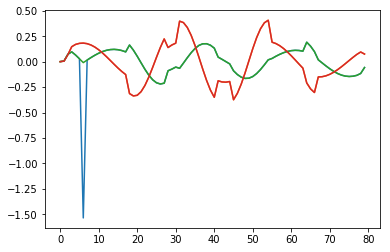

In [31]:
curl_op, eps_op = get_A_ops_1d(np.ones(perms.shape), NPML)
curl_op = np.asarray(curl_op)
E = Ez.flatten()

curl_curl_E = (SCALE / L0**2) * curl_op @ E
epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * perms * E

plt.plot(np.real(curl_curl_E))
plt.plot(np.imag(curl_curl_E))
plt.plot(np.real(epsilon_E))
plt.plot(np.imag(epsilon_E))

plt.show()

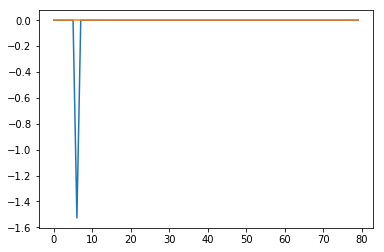

In [32]:
zero = curl_curl_E-epsilon_E
plt.plot(np.real(zero))
plt.plot(np.imag(zero))
plt.show()

In [35]:
(curl_curl_E+epsilon_E)[16+32]

-1.5268139564659675

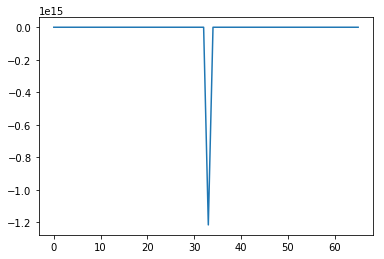

In [23]:
A = sim.A.todense()
curl=np.real(np.asarray(A[15:-15,15:-15] @ np.real(Ez)[15:-15].flatten()))[0]
plt.plot(curl)
plt.show()

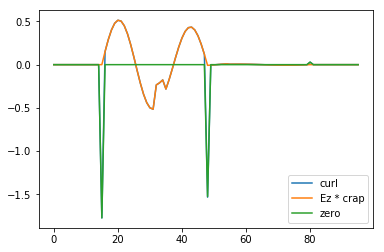

In [22]:
# plt.plot(perms[15:-15], label="eps")

curl_curl, other = get_curl_operator()

# fields = np.array([np.zeros(16), np.real(Ez)[16:-16], np.zeros(16)]).flatten()
fields = np.pad(np.real(Ez).flatten()[16:-16], (16,16), 'constant')

# curl=np.real(np.asarray(curl_curl[15:-15,15:-15] @ np.real(Ez)[15:-15].flatten()))[0]
curl=np.real(SCALE / (L0**2) * np.asarray(curl_curl @ fields))[0]
plt.plot(curl, label="curl")

# o2 = perms[15:-15] * np.real(np.asarray(other[15:-15,15:-15] @ np.real(Ez)[15:-15].flatten()))[0]
# o2 = perms * np.real(np.asarray(other @ fields))[0]
o2 = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * perms * fields

src = np.zeros(fields.shape)
src[32] = SCALE * OMEGA

plt.plot(o2, label='Ez * crap')
# plt.ylim([-200,200])

zero = curl - o2
plt.plot(zero, label='zero')

# plt.plot(fields, label='fields')
plt.legend()
plt.show()

In [23]:
Ez.shape

(96, 1)

In [25]:
zero[16]

4.190374297552424e-09

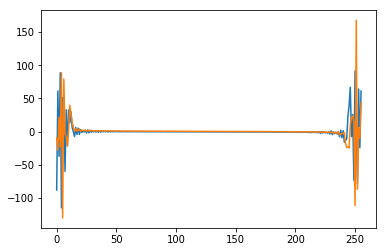

In [16]:
fft = np.fft.fft(Ez[0][32:-32])
plt.plot(np.real(fft))
plt.plot(np.imag(fft))
# plt.plot(np.fft.ifft(fft))
# plt.plot(perms[0], label="eps")

plt.show()

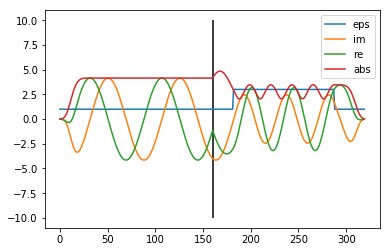

In [110]:
plt.plot(perms[0], label="eps")
plt.plot(np.imag(Ez[0]), label="im")
plt.plot(np.real(Ez[0]), label="re")
plt.vlines(src_x, -10,10)
plt.plot(np.abs(Ez[0]), label="abs")
# plt.plot(np.angle(Ez[0]), label="angle")
plt.legend()
plt.show()

In [63]:
from angler import Simulation
import numpy as np
import scipy

omega = 2*np.pi*2e14
eps_r = np.ones((8,1))
eps_r[:2] = -1e19
eps_r[-2:] = -1e19
S = Simulation(omega, eps_r, 0.01, [0, 0], 'Ez')
A = S.A.todense()
null = scipy.linalg.null_space(A).T

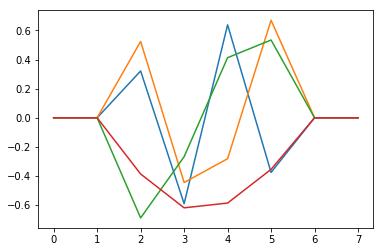

In [64]:
freqs = [np.fft.fft(n[2:-2]) for n in null]
# [plt.plot(np.real(freq)) for freq in freqs]
[plt.plot(np.real(n)) for n in null]
plt.show()

(200,)